# Fake News Prediction

## Preparation

In [1]:
!pip install kaggle
!pip install pyspellchecker

     |████████████████████████████████| 1.9MB 4.7MB/s 


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"farelyue","key":"9c727ff6cb5fedf249b144a8529fe494"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Change the permission
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

 41% 17.0M/41.0M [00:00<00:00, 28.0MB/s]
100% 41.0M/41.0M [00:00<00:00, 69.9MB/s]


In [4]:
from zipfile import ZipFile

file_name = "fake-and-real-news-dataset.zip"

with ZipFile(file_name, "r") as files:
  files.extractall()
  print("Done")

Done


In [5]:
#Library

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import string
import re

from collections import defaultdict
from collections import Counter

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.util import ngrams
stop = list(stopwords.words("english"))


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, log_loss,confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from spellchecker import SpellChecker

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

In [0]:
fake["type"] = 1
true["type"] = 0

In [0]:
lst = []
for text in true["text"]:
  temp = re.sub(r"^.*Reuters+\W+[-]+\W", r"", text)
  lst.append(temp)

In [0]:
true["text"] = lst

In [0]:
df = pd.concat([fake,true], axis = 0).reset_index(drop = True)

In [11]:
df.head()

,title,text,subject,date,type
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


## Exploratory Data Analysis

### Visualization of Target Label (Type)

Text(0.5, 1.0, 'Bar Chart of Type')

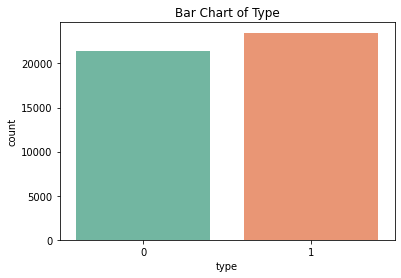

In [12]:
ax = sns.countplot(x = "type", data = df, palette = "Set2")
ax.set_title("Bar Chart of Type")

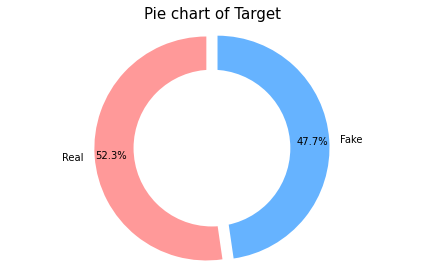

In [13]:
#Pie chart of Target
labels = ['Real', 'Fake']
values = df['type'].value_counts()
colors = ['#ff9999','#66b3ff']
explode = (0.05,0.05)

fig1, ax1 = plt.subplots()

plt.pie(values, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax1.axis('equal')
ax1.set_title("Pie chart of Target", 
              fontdict = {'fontsize' : 15,
                          'fontweight' : 10},
              loc = 'center')
plt.tight_layout()
plt.show()

In [0]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

### Word Cloud Text

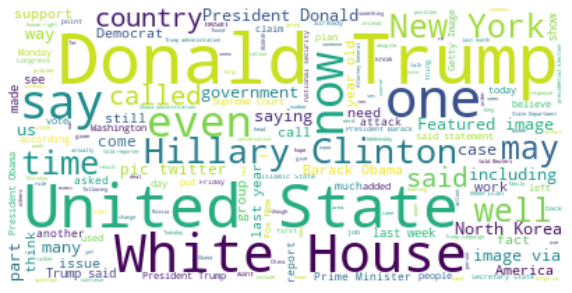

In [15]:
#Join question into one text
text = " ".join(text for text in df['text'])

#Create Stopword List
stopwords = set(STOPWORDS)

#Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

#Display the generated image
plt.figure(figsize = (10,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Word Cloud Fake

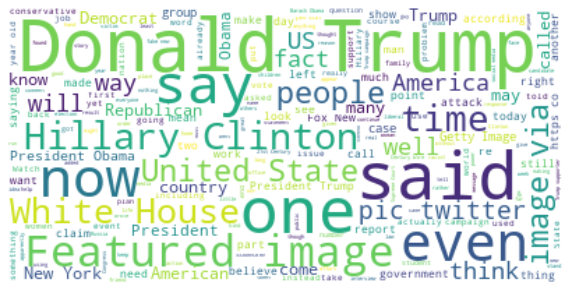

In [16]:
#Join question into one text
text_fake = df.loc[df["type"] == 1, "text"]
text = " ".join(text for text in text_fake)

#Create Stopword List
stopwords = set(STOPWORDS)

#Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

#Display the generated image
plt.figure(figsize = (10,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Word Cloud Real

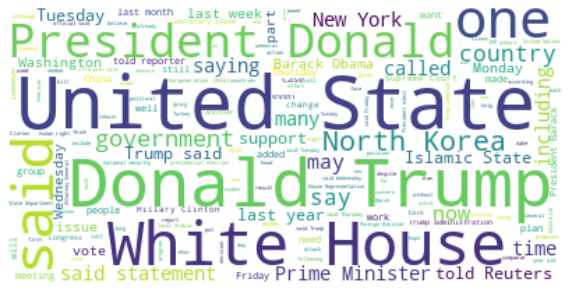

In [17]:
#Join question into one text
text_real = df.loc[df["type"] == 0, "text"]
text = " ".join(text for text in text_real)

#Create Stopword List
stopwords = set(STOPWORDS)

#Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

#Display the generated image
plt.figure(figsize = (10,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Number of Character

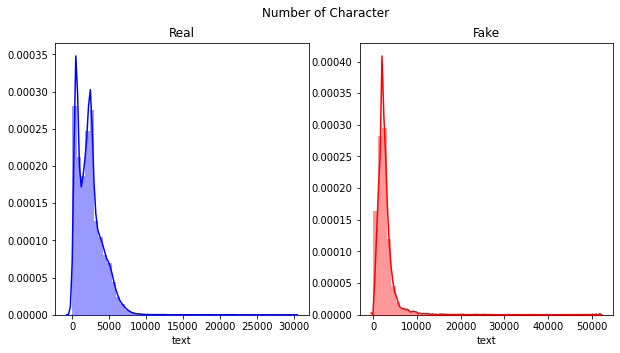

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

num_char1 = df.loc[df['type'] == 0, "text"].str.len()
sns.distplot(num_char1, ax = ax1, color = "blue")
ax1.set_title("Real")

num_char2 = df.loc[df['type'] == 1, "text"].str.len()
sns.distplot(num_char2, ax = ax2, color = "red")
ax2.set_title("Fake")

fig.suptitle("Number of Character")
plt.show()

### Number of word



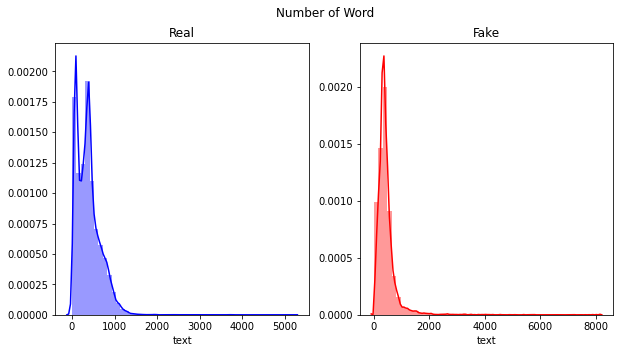

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

num_word1 = df.loc[df['type'] == 0, "text"].str.split().map(lambda x : len(x))
sns.distplot(num_word1, ax = ax1, color = "blue")
ax1.set_title("Real")

num_word2 = df.loc[df['type'] == 1, "text"].str.split().map(lambda x : len(x))
sns.distplot(num_word2, ax = ax2, color = "red")
ax2.set_title("Fake")

fig.suptitle("Number of Word")

plt.show()

### Mean of character in word



/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


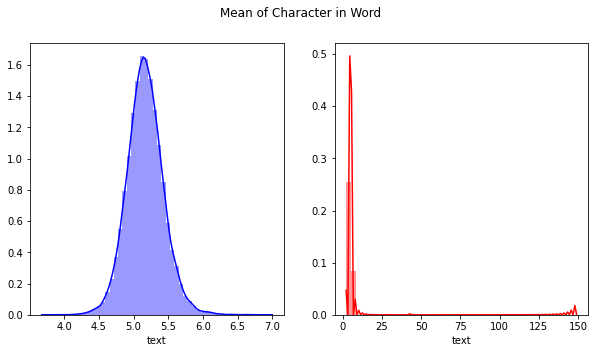

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

mean_char1 = df.loc[df["type"] == 0, "text"].str.split().map(lambda x : [len(i) for i in x])
sns.distplot(mean_char1.map(lambda x : np.mean(x)), ax = ax1, color = "blue")

mean_char2 = df.loc[df["type"] == 1, "text"].str.split().map(lambda x : [len(i) for i in x])
sns.distplot(mean_char2.map(lambda x : np.mean(x)), ax = ax2, color = "red")

fig.suptitle("Mean of Character in Word")
plt.show()

### Stopwords Analysis



In [0]:
# Make Corpus

def make_corpus(type):
  corpus = []

  for text in df.loc[df["type"] == type, "text"].str.split():
    for word in text:
      corpus.append(word.lower())
  
  return(corpus)

#### Corpus - Real

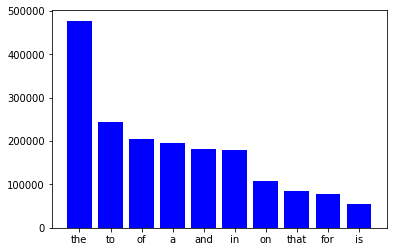

In [22]:
corpus_real = make_corpus(0)
dic_real = defaultdict(int)

for word in corpus_real:
  if word in stop:
    dic_real[word] = dic_real[word] + 1

top = sorted(dic_real.items(), key = lambda x : x[1], reverse = True)[:10]

x,y = zip(*top)
plt.bar(x,y, color = "blue");

#### Corpus - Fake

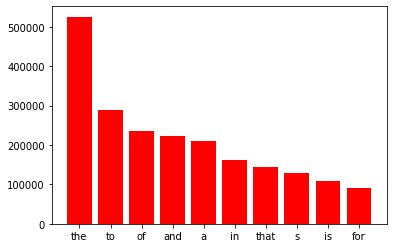

In [23]:
corpus_fake = make_corpus(1)
dic_fake = defaultdict(int)

for word in corpus_fake:
  if word in stop:
    dic_fake[word] = dic_fake[word] + 1

top = sorted(dic_fake.items(), key = lambda x : x[1], reverse = True)[:10]

x,y = zip(*top)
plt.bar(x,y, color = "red");

### Punctuation Analysis


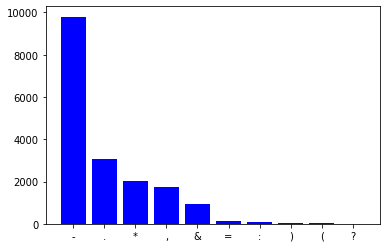

In [24]:
# Corpus Real

dic_real = defaultdict(int)
punct = string.punctuation

for word in corpus_real:
  if word in punct:
    dic_real[word] = dic_real[word] + 1

top = sorted(dic_real.items(), key = lambda x : x[1], reverse = True)[:10]

x,y = zip(*top)
plt.bar(x,y, color = "blue");

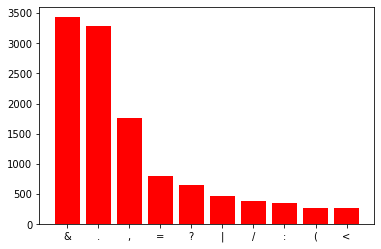

In [25]:
# Corpus Fake

dic_fake = defaultdict(int)
punct = string.punctuation

for word in corpus_fake:
  if word in punct:
    dic_fake[word] = dic_fake[word] + 1

top = sorted(dic_fake.items(), key = lambda x : x[1], reverse = True)[:10]

x,y = zip(*top)
plt.bar(x,y, color = "red");

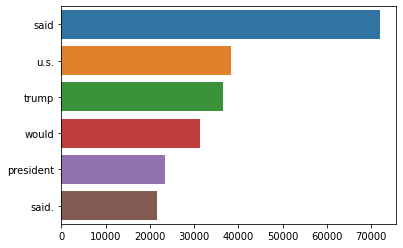

In [26]:
counter = Counter(corpus_real)
most = counter.most_common()

x = []
y = []

for word, count in most[:40]:
  if word not in stop:
    x.append(word)
    y.append(count)

sns.barplot(x = y, y = x);

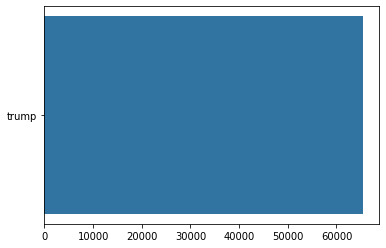

In [27]:
counter = Counter(corpus_fake)
most = counter.most_common()

x = []
y = []

for word,count in most[:40]:
  if word not in stop:
    x.append(word)
    y.append(count)

sns.barplot(x = y, y = x);

### Bi-gram Analysis

In [0]:
corpus = corpus_fake + corpus_real

def get_top_bigram(corpus, n=None):

  vec = CountVectorizer(ngram_range = (2,2)).fit(corpus)
  bow = vec.transform(corpus)
  sum_word = bow.sum(axis = 0)
  word_freq = [(word, sum_word[0,idx]) for word, idx in vec.vocabulary_.items()]
  word_freq = sorted(word_freq, key = lambda x : x[1], reverse= True)

  return word_freq[:n]

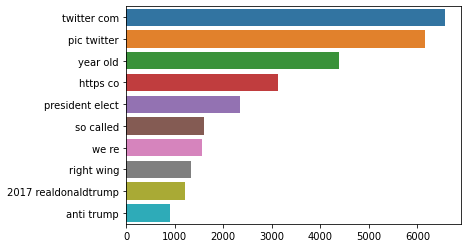

In [29]:
top_bigram = get_top_bigram(corpus, 10)

x,y = map(list, zip(*top_bigram))
sns.barplot(x = y, y = x);

## Preprocessing



### Cleaning

In [0]:
def remove_url(text):
  url = re.compile(r"https?://\S+|www\.\S+")
  return url.sub(r"", text)

In [0]:
def remove_html(text):
  html = re.compile(r"<.*?>")
  return html.sub(r"", text)

In [0]:
def remove_emoji(text):
    emoji = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji.sub(r'', text)

In [0]:
def remove_punct(text):
  punct = re.compile(r'[!"#$%&\\\'()*+,-./:;<=>?@[\\\]^_`{|}~]')
  return punct.sub("", text)

In [0]:
def spell_checking(text):

  spell = SpellChecker()
  correct = []

  miss_spell = spell.unknown(text.split())

  for word in text.split():
    if word in miss_spell:
      correct.append(spell.correction(word))
    else:
      correct.append(word)
  
  return " ".join(correct)

In [0]:
def remove_stopword(text):
  temp = [word for word in text if word not in stop]
  return temp

In [0]:
def remove_single_alphabet(text):
  temp = [word for word in text if word not in string.ascii_lowercase]
  return temp

In [0]:
def cleaning_text(text):
  text = text.apply(lambda x : remove_url(x))
  text = text.apply(lambda x : remove_html(x))
  text = text.apply(lambda x : remove_emoji(x))
  text = text.apply(lambda x : x.lower())
  text = text.apply(lambda x : remove_punct(x))
  # text = text.apply(lambda x : spell_checking(x))
  return text 

In [0]:
def list_to_string(text):
  return " ".join(text)

In [0]:
df["text"] = cleaning_text(df["text"])
df["text"] = df["text"].apply(lambda x : x.lower())
df["text"] = df["text"].apply(lambda x : x.split())
df["text"] = df["text"].apply(remove_stopword)
df["text"] = df["text"].apply(remove_single_alphabet)
df["text"] = df["text"].apply(list_to_string)

In [40]:
df["text"]

0        donald trump wish americans happy new year lea...
1        house intelligence committee chairman devin nu...
2        friday revealed former milwaukee sheriff david...
3        christmas day donald trump announced would bac...
4        pope francis used annual christmas day message...
                               ...                        
44893    nato allies tuesday welcomed president donald ...
44894    lexisnexis provider legal regulatory business ...
44895    shadow disused sovietera factories minsk stree...
44896    vatican secretary state cardinal pietro paroli...
44897    indonesia buy 11 sukhoi fighter jets worth 114...
Name: text, Length: 44898, dtype: object

### Splitting Train & Test

In [0]:
# Splitting
from sklearn.model_selection import train_test_split

X = df["text"]
y = df["type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 18)

## Feature Extraction



### Bag of Words



### GloVe Vectorization

## Modelling



### Random Forest



### Naive Bayes



### Neural Network